# TimeGAN Example Usage

This notebook demonstrates how to use TimeGAN to generate synthetic time series data.

## Steps:
1. Generate mock stochastic exponential time series data (Geometric Brownian Motion)
2. Preprocess data using preprocessing utilities
3. Train TimeGAN model
4. Generate synthetic samples


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

project_root = Path().resolve().parents[0].parents[0]
sys.path.append(str(project_root))

from src.models.non_parametric.time_gan import TimeGAN
from src.utils.preprocessing_utils import (
    LogReturnTransformation,
    preprocess_non_parametric,
    create_dataloaders
)


## Step 1: Generate Mock Stochastic Exponential Time Series Data

We'll generate a Geometric Brownian Motion (GBM) time series, which is commonly used for modeling stock prices.


Generated 10001 days of price data
Price range: [74.61, 232.27]


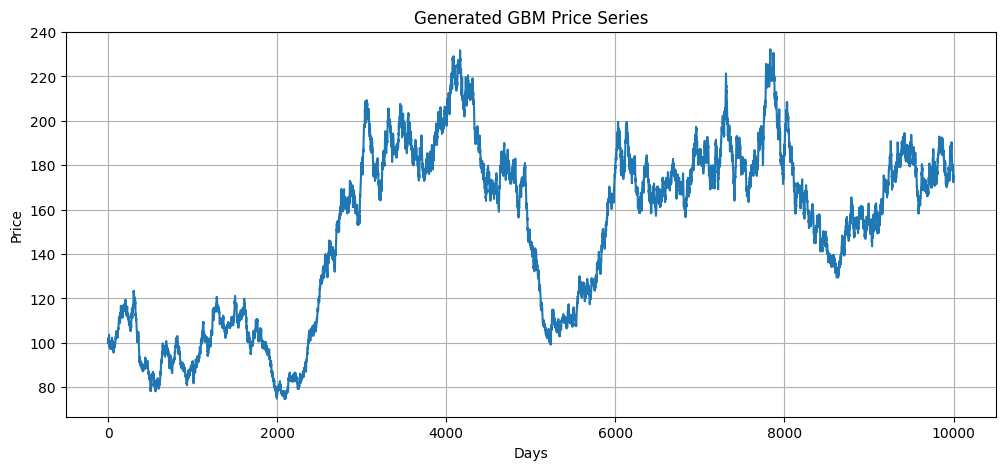

In [3]:
def generate_gbm_prices(
    initial_price: float = 100.0,
    mu: float = 0.05,  # Annual drift
    sigma: float = 0.2,  # Annual volatility
    num_days: int = 1000,
    dt: float = 1/252,  # Daily time step (252 trading days per year)
    seed: int = 42
) -> torch.Tensor:
    """
    Generate Geometric Brownian Motion price series.
    
    Args:
        initial_price: Starting price
        mu: Annual drift rate
        sigma: Annual volatility
        num_days: Number of days to simulate
        dt: Time step (default: daily)
        seed: Random seed
    
    Returns:
        Price series as torch.Tensor
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Generate random shocks
    Z = torch.randn(num_days)
    
    # GBM: dS = mu*S*dt + sigma*S*dW
    # In log space: d(log S) = (mu - 0.5*sigma^2)*dt + sigma*dW
    log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    
    # Convert log returns to prices
    log_prices = torch.cumsum(torch.cat([torch.tensor([np.log(initial_price)]), log_returns]), dim=0)
    prices = torch.exp(log_prices)
    
    return prices

# Generate synthetic price data
original_prices = generate_gbm_prices(
    initial_price=100.0,
    mu=0.03,  # 8% annual return
    sigma=0.15,  # 25% annual volatility
    num_days=10000,
    seed=40
)

print(f"Generated {len(original_prices)} days of price data")
print(f"Price range: [{original_prices.min():.2f}, {original_prices.max():.2f}]")

# Visualize the generated data
plt.figure(figsize=(12, 5))
plt.plot(original_prices.numpy())
plt.title('Generated GBM Price Series')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.show()


## Step 2: Preprocess Data

Convert prices to log returns and create sliding windows for non-parametric models.


Log returns shape: torch.Size([10000])
Log returns stats: mean=0.000056, std=0.009374

Preprocessed data shapes:
Train: torch.Size([7920, 100])
Valid: torch.Size([990, 100])
Test: torch.Size([991, 100])


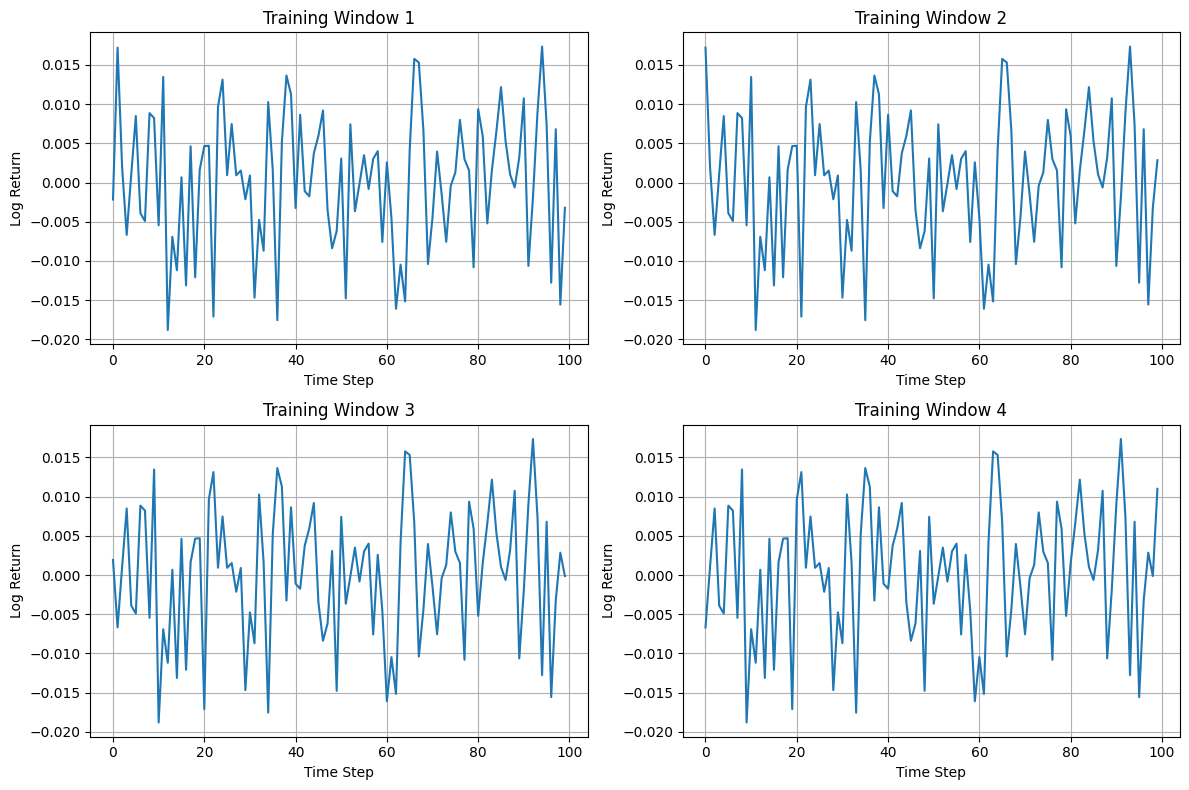

In [4]:
# Convert prices to log returns
scaler = LogReturnTransformation()
log_returns, initial_value = scaler.transform(original_prices)

print(f"Log returns shape: {log_returns.shape}")
print(f"Log returns stats: mean={log_returns.mean():.6f}, std={log_returns.std():.6f}")

# Preprocess for non-parametric model
seq_length = 100  # Window size for time series
train_data, valid_data, test_data, train_initial, valid_initial, test_initial = preprocess_non_parametric(
    ori_data=log_returns,
    original_prices=original_prices,
    seq_length=seq_length,
    valid_ratio=0.1,
    test_ratio=0.1,
    stride=1
)

print(f"\nPreprocessed data shapes:")
print(f"Train: {train_data.shape}")
print(f"Valid: {valid_data.shape}")
print(f"Test: {test_data.shape}")

# Visualize a few training windows
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i in range(4):
    axes[i].plot(train_data[i].numpy())
    axes[i].set_title(f'Training Window {i+1}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Log Return')
    axes[i].grid(True)
plt.tight_layout()
plt.show()


## Step 3: Create DataLoaders

Create PyTorch DataLoaders for training.


In [5]:
# Create DataLoaders
batch_size = 128
train_loader, valid_loader, test_loader = create_dataloaders(
    train_data=train_data,
    valid_data=valid_data,
    test_data=test_data,
    batch_size=batch_size,
    train_initial=train_initial,
    valid_initial=valid_initial,
    test_initial=test_initial,
    num_workers=0,
    pin_memory=False
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Check batch shape
sample_batch, sample_initial = next(iter(train_loader))
print(f"\nBatch shape: {sample_batch.shape}")
print(f"Initial values shape: {sample_initial.shape}")


Number of training batches: 62
Number of validation batches: 8
Number of test batches: 8

Batch shape: torch.Size([128, 100])
Initial values shape: torch.Size([128])


## Step 4: Initialize and Train TimeGAN

Create TimeGAN model and train it on the preprocessed data.


In [6]:
# Initialize TimeGAN model
model = TimeGAN(
    seq_len=seq_length,
    learning_rate=1e-4,
    batch_size=batch_size,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"TimeGAN model initialized on device: {model.device}")


TimeGAN model initialized on device: cpu


In [ ]:
print("Starting TimeGAN training...")
print("Note: TimeGAN training has 3 stages, each with num_epochs iterations")
print("This may take a while - be patient!")
model.fit(
    data_loader=train_loader,
    num_epochs=1000
)
print("\nTraining complete!")


Starting TimeGAN training...
Note: TimeGAN training has 3 stages, each with num_epochs iterations
This may take a while - be patient!
Preprocessing data...
Start Embedding Network Training
epoch: 0/1000, e_loss: 1.0548


## Step 5: Generate Synthetic Samples

Generate synthetic time series samples using the trained model.


In [ ]:
# Generate synthetic samples
num_samples = 100
generation_length = seq_length

print(f"Generating {num_samples} synthetic samples of length {generation_length}...")
generated_samples = model.generate(
    num_samples=num_samples,
    generation_length=generation_length,
    seed=123
)

print(f"Generated samples shape: {generated_samples.shape}")
print(f"Generated samples stats: mean={generated_samples.mean():.6f}, std={generated_samples.std():.6f}")

# Compare with real data
print(f"\nReal data stats: mean={train_data.mean():.6f}, std={train_data.std():.6f}")


Generating 100 synthetic samples of length 100...
Generated samples shape: torch.Size([100, 100])
Generated samples stats: mean=-0.000000, std=0.000078

Real data stats: mean=0.000080, std=0.009369


## Step 6: Visualize Results

Compare generated samples with real training data.


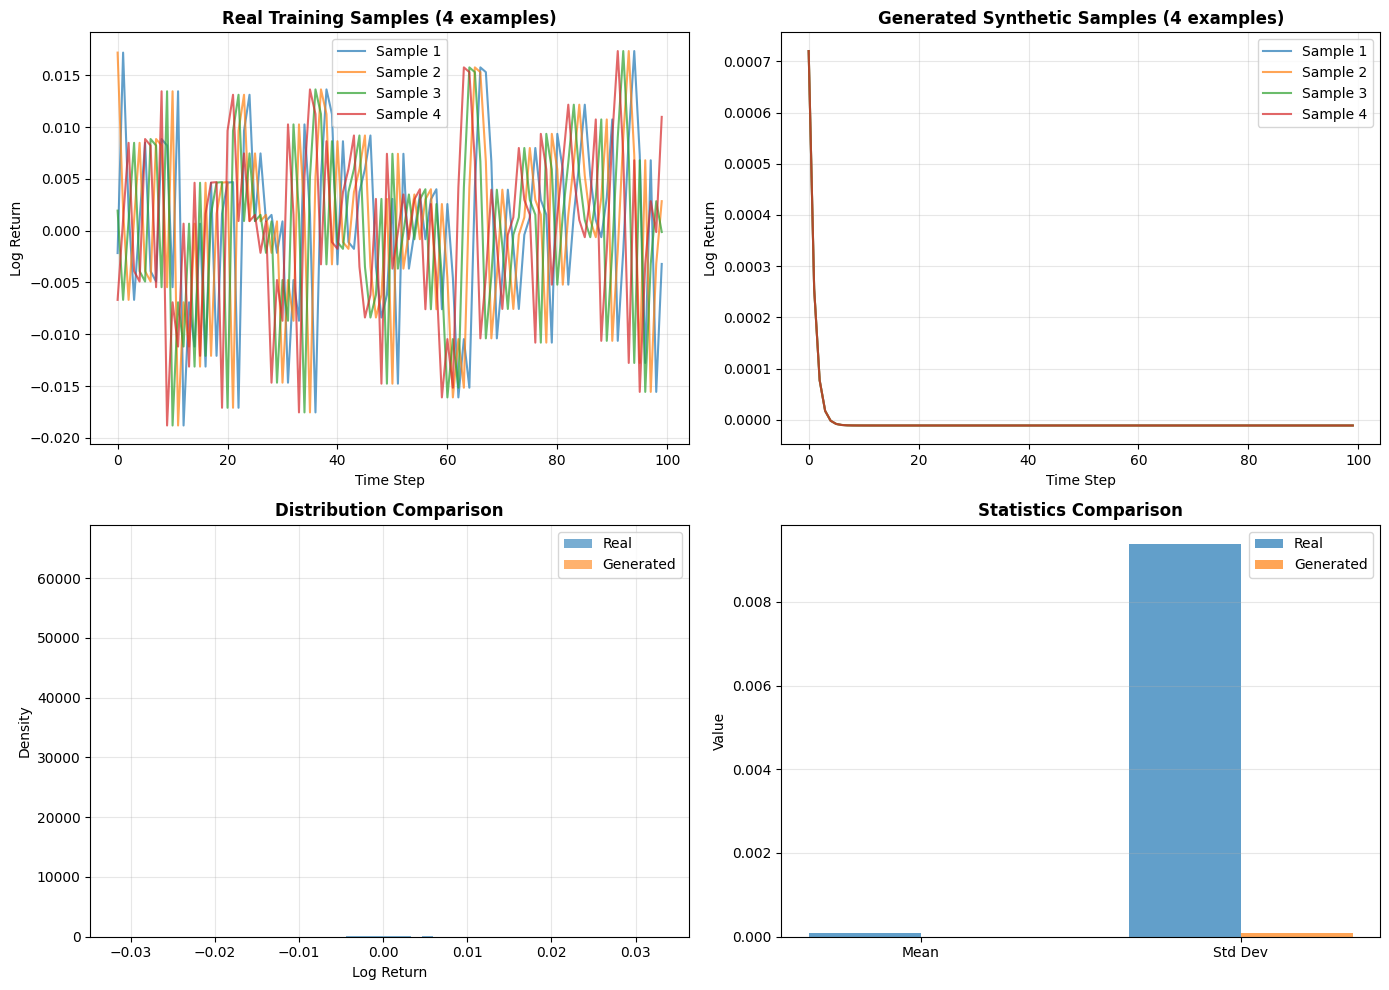


Statistics Summary:
Real data - Mean: 0.000080, Std: 0.009369
Generated - Mean: -0.000000, Std: 0.000078


In [ ]:
# Visualize generated vs real samples
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Real training samples
axes[0, 0].set_title('Real Training Samples (4 examples)', fontsize=12, fontweight='bold')
for i in range(min(4, len(train_data))):
    axes[0, 0].plot(train_data[i].numpy(), alpha=0.7, label=f'Sample {i+1}')
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Log Return')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Generated samples
axes[0, 1].set_title('Generated Synthetic Samples (4 examples)', fontsize=12, fontweight='bold')
for i in range(min(4, num_samples)):
    axes[0, 1].plot(generated_samples[i].numpy(), alpha=0.7, label=f'Sample {i+1}')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Log Return')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Distribution comparison
axes[1, 0].set_title('Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 0].hist(train_data.flatten().numpy(), bins=50, alpha=0.6, label='Real', density=True)
axes[1, 0].hist(generated_samples.flatten().numpy(), bins=50, alpha=0.6, label='Generated', density=True)
axes[1, 0].set_xlabel('Log Return')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Statistics comparison
axes[1, 1].set_title('Statistics Comparison', fontsize=12, fontweight='bold')
real_mean = train_data.mean().item()
real_std = train_data.std().item()
gen_mean = generated_samples.mean().item()
gen_std = generated_samples.std().item()

categories = ['Mean', 'Std Dev']
real_stats = [real_mean, real_std]
gen_stats = [gen_mean, gen_std]

x = np.arange(len(categories))
width = 0.35

axes[1, 1].bar(x - width/2, real_stats, width, label='Real', alpha=0.7)
axes[1, 1].bar(x + width/2, gen_stats, width, label='Generated', alpha=0.7)
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nStatistics Summary:")
print(f"Real data - Mean: {real_mean:.6f}, Std: {real_std:.6f}")
print(f"Generated - Mean: {gen_mean:.6f}, Std: {gen_std:.6f}")


Start Embedding Network Training
step: 0/1, e_loss: 0.1414
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/1, e_loss: 0.0496
Start Joint Training
step: 0/1, d_loss: 2.0831, g_loss_u: 0.7014, g_loss_s: 0.0383, g_loss_v: 0.3958, e_loss_t0: 0.1391
Finish Joint Training
Start Testing
Finish Synthetic Data Generation


/var/folders/5g/xd1_vnlj2zg4df463t644sgw0000gn/T/ipykernel_63118/1185312845.py:164: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  self.Z = torch.tensor(self.Z, dtype=torch.float32).to(self.device)


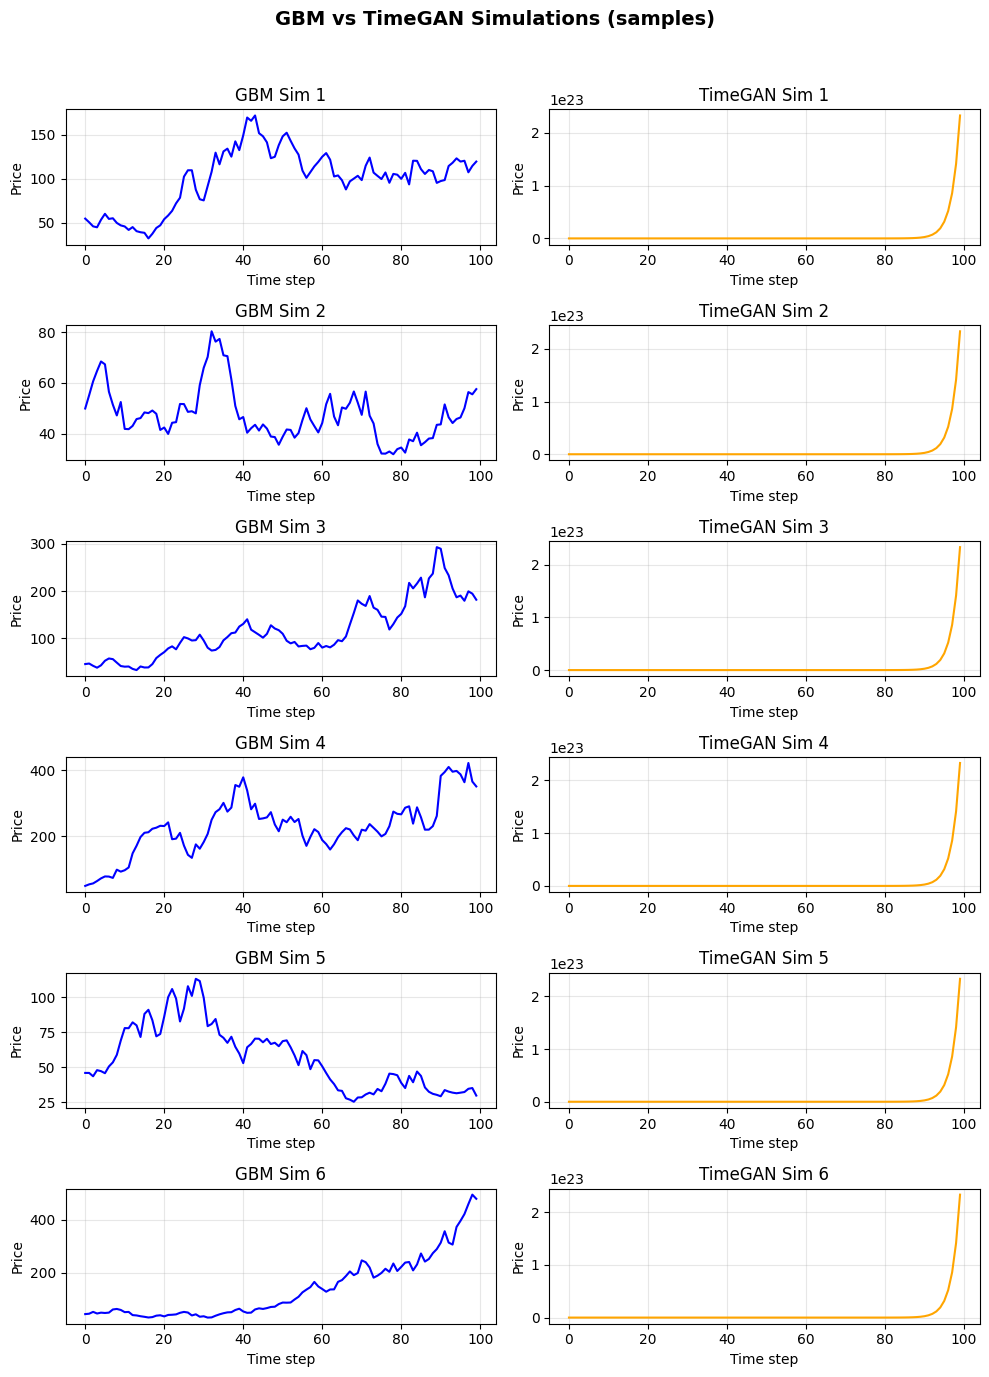

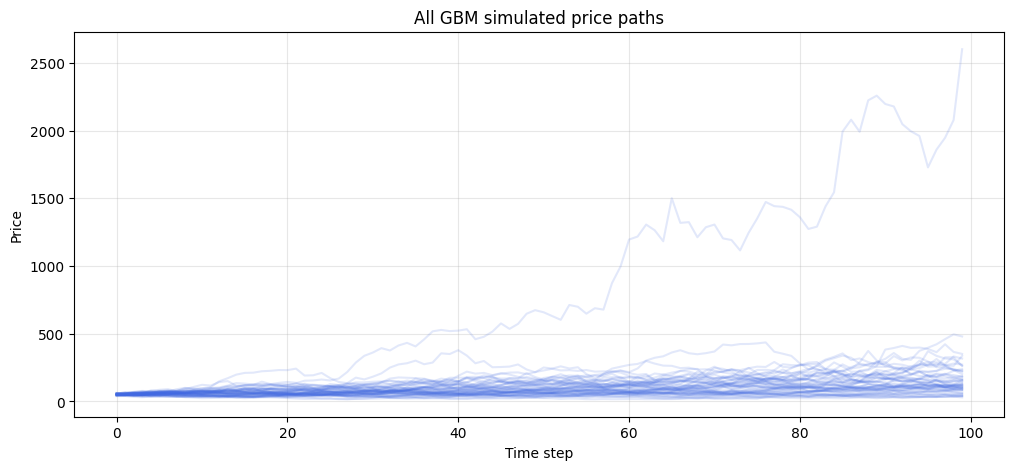

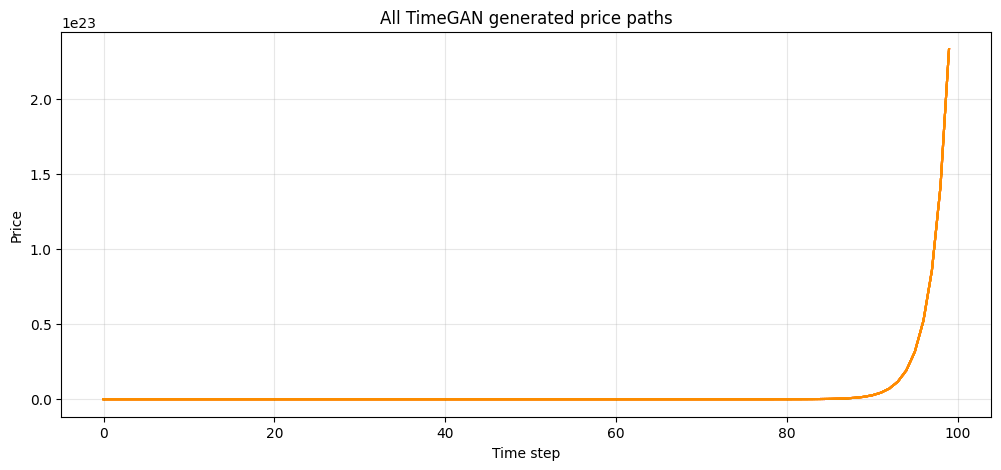

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn

class Embedder(nn.Module):
    def __init__(self, para):
        super(Embedder, self).__init__()
        self.rnn = nn.GRU(input_size=para['input_dim'], hidden_size=para['hidden_dim'], num_layers=para['num_layer'], batch_first=True)
        self.fc = nn.Linear(para['hidden_dim'], para['hidden_dim'])
        self.sigmoid = nn.Sigmoid()
    def forward(self, X):
        e_outputs, _ = self.rnn(X)
        H = self.fc(e_outputs)
        H = self.sigmoid(H)
        return H

class Recovery(nn.Module):
    def __init__(self, para):
        super(Recovery, self).__init__()
        self.rnn = nn.GRU(input_size=para['hidden_dim'], hidden_size=para['input_dim'], num_layers=para['num_layer'], batch_first=True)
        self.fc = nn.Linear(para['input_dim'], para['input_dim'])
        self.sigmoid = nn.Sigmoid()
    def forward(self, H):
        r_outputs, _ = self.rnn(H)
        X_tilde = self.fc(r_outputs)
        X_tilde = self.sigmoid(X_tilde)
        return X_tilde

class Generator(nn.Module):
    def __init__(self, para):
        super(Generator, self).__init__()
        self.rnn = nn.GRU(input_size=para['input_dim'], hidden_size=para['hidden_dim'], num_layers=para['num_layer'], batch_first=True)
        self.fc = nn.Linear(para['hidden_dim'], para['hidden_dim'])
        self.sigmoid = nn.Sigmoid()
    def forward(self, Z):
        g_outputs, _ = self.rnn(Z)
        E = self.fc(g_outputs)
        E = self.sigmoid(E)
        return E

class Supervisor(nn.Module):
    def __init__(self, para):
        super(Supervisor, self).__init__()
        self.rnn = nn.GRU(input_size=para['hidden_dim'], hidden_size=para['hidden_dim'], num_layers=(para['num_layer'] - 1 if para['num_layer'] > 1 else 1), batch_first=True)
        self.fc = nn.Linear(para['hidden_dim'], para['hidden_dim'])
        self.sigmoid = nn.Sigmoid()
    def forward(self, H):
        s_outputs, _ = self.rnn(H)
        S = self.fc(s_outputs)
        S = self.sigmoid(S)
        return S

class Discriminator(nn.Module):
    def __init__(self, para):
        super(Discriminator, self).__init__()
        self.rnn = nn.GRU(input_size=para['hidden_dim'], hidden_size=para['hidden_dim'], num_layers=para['num_layer'], batch_first=True)
        self.fc = nn.Linear(para['hidden_dim'], para['hidden_dim'])
        self.sigmoid = nn.Sigmoid()
    def forward(self, H):
        d_outputs, _ = self.rnn(H)
        Y = self.fc(d_outputs)
        Y = self.sigmoid(Y)
        return Y


def train_test_divide(data_x, data_x_hat, data_t, data_t_hat, train_rate=0.8):
    no = len(data_x)
    idx = np.random.permutation(no)
    train_idx = idx[:int(no * train_rate)]
    test_idx = idx[int(no * train_rate):]
    train_x = [data_x[i] for i in train_idx]
    test_x = [data_x[i] for i in test_idx]
    train_t = [data_t[i] for i in train_idx]
    test_t = [data_t[i] for i in test_idx]
    no = len(data_x_hat)
    idx = np.random.permutation(no)
    train_idx = idx[:int(no * train_rate)]
    test_idx = idx[int(no * train_rate):]
    train_x_hat = [data_x_hat[i] for i in train_idx]
    test_x_hat = [data_x_hat[i] for i in test_idx]
    train_t_hat = [data_t_hat[i] for i in train_idx]
    test_t_hat = [data_t_hat[i] for i in test_idx]
    return train_x, train_x_hat, test_x, test_x_hat, train_t, train_t_hat, test_t, test_t_hat

def MinMaxScaler(data):
    min_val = np.min(np.min(data, axis=0), axis=0)
    data = data - min_val
    max_val = np.max(np.max(data, axis=0), axis=0)
    norm_data = data / (max_val + 1e-7)
    return norm_data, min_val, max_val

def extract_time(data):
    time = list()
    max_seq_len = 0
    for i in range(len(data)):
        max_seq_len = max(max_seq_len, len(data[i][:, 0]))
        time.append(len(data[i][:, 0]))
    return time, max_seq_len

def random_generator(batch_size, z_dim, max_seq_len, *T):
    Z_mb = list()
    for i in range(batch_size):
        if not T or T[0] is None:
            temp = np.random.uniform(0., 1, [max_seq_len, z_dim])
        else:
            T_mb = T[0]
            temp = np.random.uniform(0., 1, [T_mb[i], z_dim])
        Z_mb.append(temp)
    return Z_mb

def batch_generator(data, time, batch_size):
    no = len(data)
    idx = np.random.permutation(no)
    train_idx = idx[:batch_size]
    X_mb = list(data[i] for i in train_idx)
    T_mb = list(time[i] for i in train_idx)
    return X_mb, T_mb

class TimeGAN:
    def __init__(self, opt, ori_data):
        self.opt = opt
        self.ori_data, self.min_val, self.max_val = MinMaxScaler(ori_data)
        self.ori_time, self.max_seq_len = extract_time(self.ori_data)
        self.no, self.seq_len, self.z_dim = np.asarray(ori_data).shape
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.para = dict()
        self.para['module'] = self.opt.module
        self.para['input_dim'] = self.z_dim
        self.para['hidden_dim'] = self.opt.hidden_dim
        self.para['num_layer'] = self.opt.num_layer
        self.embedder = Embedder(self.para).to(self.device)
        self.recovery = Recovery(self.para).to(self.device)
        self.generator = Generator(self.para).to(self.device)
        self.discriminator = Discriminator(self.para).to(self.device)
        self.supervisor = Supervisor(self.para).to(self.device)
        self.optim_embedder = torch.optim.Adam(self.embedder.parameters(), lr=self.opt.lr)
        self.optim_recovery = torch.optim.Adam(self.recovery.parameters(), lr=self.opt.lr)
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=self.opt.lr)
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=self.opt.lr)
        self.optim_supervisor = torch.optim.Adam(self.supervisor.parameters(), lr=self.opt.lr)
        self.MSELoss = torch.nn.MSELoss()
        self.BCELoss = torch.nn.BCELoss()
        if getattr(self.opt, "load_checkpoint", False):
            self.load_trained_networks()

    def gen_batch(self):
        self.X, self.T = batch_generator(self.ori_data, self.ori_time, self.opt.batch_size)
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32).to(self.device)
        self.Z = random_generator(self.opt.batch_size, self.para['input_dim'], self.max_seq_len, self.T)
        self.Z = torch.tensor(np.array(self.Z), dtype=torch.float32).to(self.device)
    def batch_forward(self):
        self.H = self.embedder(self.X)
        self.X_tilde = self.recovery(self.H)
        self.H_hat_supervise = self.supervisor(self.H)
        self.E_hat = self.generator(self.Z)
        self.H_hat = self.supervisor(self.E_hat)
        self.X_hat = self.recovery(self.H_hat)
        self.Y_real = self.discriminator(self.H)
        self.Y_fake = self.discriminator(self.H_hat)
        self.Y_fake_e = self.discriminator(self.E_hat)
    def gen_synth_data(self, batch_size):
        self.Z = random_generator(batch_size, self.para['input_dim'], self.max_seq_len, self.ori_time)
        self.Z = torch.tensor(self.Z, dtype=torch.float32).to(self.device)
        self.E_hat = self.generator(self.Z)
        self.H_hat = self.supervisor(self.E_hat)
        self.X_hat = self.recovery(self.H_hat)
        return self.X_hat
    def train_embedder(self, join_train=False):
        self.embedder.train()
        self.recovery.train()
        self.optim_embedder.zero_grad()
        self.optim_recovery.zero_grad()
        self.E_loss_T0 = self.MSELoss(self.X, self.X_tilde)
        self.E_loss0 = 10 * torch.sqrt(self.E_loss_T0)
        if not join_train:
            self.E_loss0.backward()
        else:
            self.G_loss_S = self.MSELoss(self.H[:, 1:, :], self.H_hat_supervise[:, :-1, :])
            self.E_loss = self.E_loss0 + 0.1 * self.G_loss_S
            self.E_loss.backward()
        self.optim_embedder.step()
        self.optim_recovery.step()
    def train_supervisor(self):
        self.generator.train()
        self.supervisor.train()
        self.optim_generator.zero_grad()
        self.optim_supervisor.zero_grad()
        self.G_loss_S = self.MSELoss(self.H[:, 1:, :], self.H_hat_supervise[:, :-1, :])
        self.G_loss_S.backward()
        self.optim_generator.step()
        self.optim_supervisor.step()
    
    def train_generator(self,join_train=False):
        self.optim_generator.zero_grad()
        self.optim_supervisor.zero_grad()
        self.G_loss_U = self.BCELoss(self.Y_fake, torch.ones_like(self.Y_fake))
        self.G_loss_U_e = self.BCELoss(self.Y_fake_e, torch.ones_like(self.Y_fake_e))
        self.G_loss_V1 = torch.mean(torch.abs(torch.sqrt(torch.std(self.X_hat, [0])[1] + 1e-6) - torch.sqrt(
            torch.std(self.X, [0])[1] + 1e-6)))
        self.G_loss_V2 = torch.mean(torch.abs((torch.mean(self.X_hat, [0])) - (torch.mean(self.X, [0]))))
        self.G_loss_V = self.G_loss_V1 + self.G_loss_V2
        self.G_loss_S = self.MSELoss(self.H_hat_supervise[:, :-1, :], self.H[:, 1:, :])
        self.G_loss = self.G_loss_U + \
                      self.opt.gamma * self.G_loss_U_e + \
                      torch.sqrt(self.G_loss_S) * 100 + \
                      self.G_loss_V * 100
        if not join_train:
            self.G_loss.backward()
        else:
            self.G_loss.backward(retain_graph=True)
        self.optim_generator.step()
        self.optim_supervisor.step()
    def train_discriminator(self):
        self.discriminator.train()
        self.optim_discriminator.zero_grad()
        self.D_loss_real = self.BCELoss(self.Y_real, torch.ones_like(self.Y_real))
        self.D_loss_fake = self.BCELoss(self.Y_fake, torch.zeros_like(self.Y_fake))
        self.D_loss_fake_e = self.BCELoss(self.Y_fake_e, torch.zeros_like(self.Y_fake_e))
        self.D_loss = self.D_loss_real + \
                      self.D_loss_fake + \
                      self.opt.gamma * self.D_loss_fake_e
        if self.D_loss > 0.15:
            self.D_loss.backward()
            self.optim_discriminator.step()


# ==== START NEW CODE: Train on GBM, plot ====
import matplotlib.pyplot as plt

def train(opt, ori_data):
    model = TimeGAN(opt, ori_data)
    per_print_num = max(1, int(opt.iterations / opt.print_times))
    print('Start Embedding Network Training')
    for i in range(opt.iterations):
        model.gen_batch()
        model.batch_forward()
        model.train_embedder()
        if i % per_print_num == 0:
            print('step: ' + str(i) + '/' + str(opt.iterations) +
                  ', e_loss: ' + str(np.round(np.sqrt(model.E_loss_T0.item()), 4)))
    print('Finish Embedding Network Training')
    print('Start Training with Supervised Loss Only')
    for i in range(opt.iterations):
        model.gen_batch()
        model.batch_forward()
        model.train_supervisor()
        if i % per_print_num == 0:
            print('step: ' + str(i) + '/' + str(opt.iterations) +
                  ', e_loss: ' + str(np.round(np.sqrt(model.G_loss_S.item()), 4)))
    print('Start Joint Training')
    for i in range(opt.iterations):
        for kk in range(2):
            model.gen_batch()
            model.batch_forward()
            model.train_generator(join_train=True)
            model.batch_forward()
            model.train_embedder(join_train=True)
        model.gen_batch()
        model.batch_forward()
        model.train_discriminator()
        if i % per_print_num == 0:
            print('step: ' + str(i) + '/' + str(opt.iterations) +
                  ', d_loss: ' + str(np.round(model.D_loss.item(), 4)) +
                  ', g_loss_u: ' + str(np.round(model.G_loss_U.item(), 4)) +
                  ', g_loss_s: ' + str(np.round(np.sqrt(model.G_loss_S.item()), 4)) +
                  ', g_loss_v: ' + str(np.round(model.G_loss_V.item(), 4)) +
                  ', e_loss_t0: ' + str(np.round(np.sqrt(model.E_loss_T0.item()), 4)))
    print('Finish Joint Training')
    # If model.save_trained_networks() exists, call it
    if hasattr(model, 'save_trained_networks'):
        model.save_trained_networks()
    return model

def test(opt, ori_data, model=None):
    print('Start Testing')
    # Only reload model if not provided
    if model is None:
        tg_model = TimeGAN(opt, ori_data)
        if hasattr(tg_model, 'load_trained_networks'):
            tg_model.load_trained_networks()
    else:
        tg_model = model
    if hasattr(opt, "synth_size") and opt.synth_size != 0:
        synth_size = opt.synth_size
    else:
        synth_size = len(ori_data)
    generated_data = tg_model.gen_synth_data(synth_size)
    generated_data = generated_data.cpu().detach().numpy()
    gen_data = list()
    for i in range(synth_size):
        temp = generated_data[i, :opt.seq_len, :]
        gen_data.append(temp)
    print('Finish Synthetic Data Generation')
    return np.array(gen_data)

# ==== GBM Data Simulation ====
def simulate_gbm_logreturns(n_paths, n_steps, mu, sigma, s0, dt=1):
    """Simulate geometric Brownian motion log returns. Returns (log_returns, init_prices)"""
    # Generate shocks: shape (n_paths, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), size=(n_paths, n_steps))
    log_returns = mu * dt + sigma * dW
    log_returns = log_returns[..., np.newaxis] # shape (n_paths, n_steps, 1)
    init_prices = np.ones(n_paths) * s0
    return log_returns, init_prices

# ==== Main code for experiment: train and plot ====
# Parameters for the experiment
n_samples = 100  # Number of series to simulate
n_steps = 100     # Length of each series
mu = 0.01        # Drift
sigma = 0.1      # Volatility
s0 = 50          # Initial price

# Generate GBM log returns
log_returns, init_prices = simulate_gbm_logreturns(n_samples, n_steps, mu, sigma, s0)

# Prepare TimeGAN options (minimal stub: you need to expand if your opt class expects more)
class Opts:
    def __init__(self):
        self.module = "gru"
        self.input_dim = 1
        self.z_dim = 1
        self.hidden_dim = 24
        self.num_layer = 3
        self.lr = 1e-3
        self.batch_size = 64
        self.iterations = 10000
        self.print_times = 5
        self.seq_len = n_steps
        self.gamma = 1
        self.load_checkpoint = False
        self.synth_size = n_samples

opt = Opts()

# Train TimeGAN on log return data
model = train(opt, log_returns)
# Generate synthetic data
generated_data = test(opt, log_returns, model=model)
# For plotting, for both: convert log returns back to prices

def log_return_to_price(log_ret_series, start_price):
    # log_ret_series: shape (steps, 1)
    # start_price: float
    prices = [start_price]
    for r in log_ret_series:
        prices.append(prices[-1] * np.exp(r[0]))
    return np.array(prices[1:])

# Select a few real and generated samples to plot
num_plot = 6
fig, ax = plt.subplots(num_plot, 2, figsize=(10, 14))
for i in range(num_plot):
    # GBM simulation
    real_prices = log_return_to_price(log_returns[i], init_prices[i])
    ax[i,0].plot(real_prices, color='blue')
    ax[i,0].set_title(f"GBM Sim {i+1}")
    # TimeGAN simulation
    synth_prices = log_return_to_price(generated_data[i], init_prices[i])
    ax[i,1].plot(synth_prices, color='orange')
    ax[i,1].set_title(f"TimeGAN Sim {i+1}")

for a in ax.flat:
    a.set_xlabel("Time step")
    a.set_ylabel("Price")
    a.grid(True, alpha=0.3)
fig.suptitle("GBM vs TimeGAN Simulations (samples)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# Separate figure for all real, all synthetic
plt.figure(figsize=(12,5))
for i in range(min(n_samples,50)):
    plt.plot(log_return_to_price(log_returns[i], init_prices[i]), color='royalblue', alpha=0.15)
plt.title("All GBM simulated price paths")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12,5))
for i in range(min(len(generated_data),50)):
    plt.plot(log_return_to_price(generated_data[i], init_prices[i]), color='darkorange', alpha=0.15)
plt.title("All TimeGAN generated price paths")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()


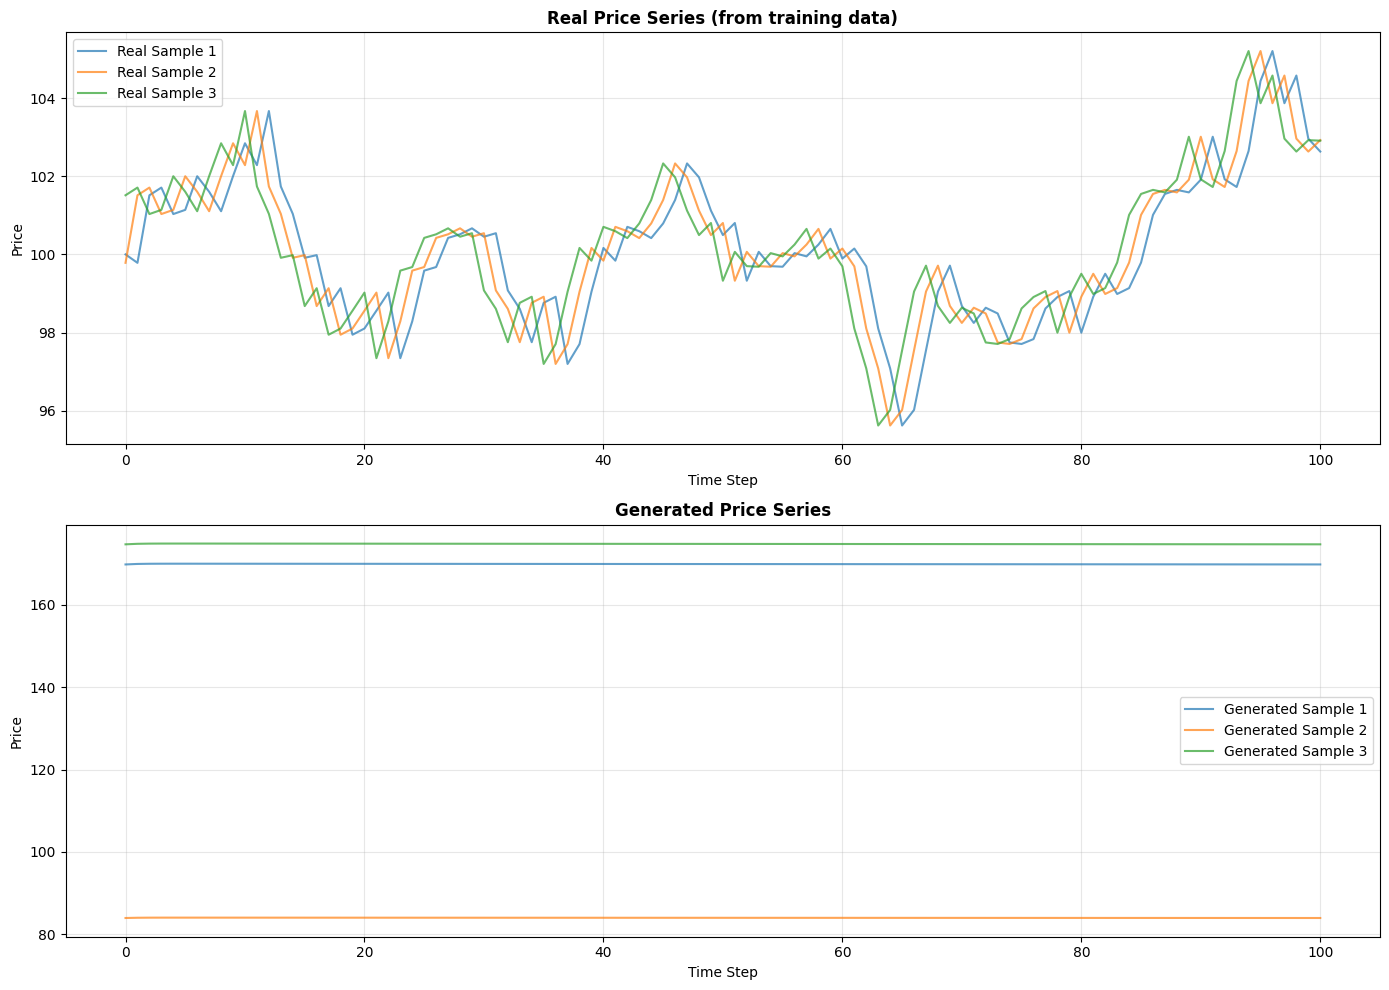


Successfully generated synthetic time series data!


In [ ]:
# Convert generated log returns back to prices
generated_prices_list = []
for i in range(num_samples):
    # Use a random initial price from the training data
    initial_price = train_initial[torch.randint(0, len(train_initial), (1,))].item()
    
    # Reconstruct prices from log returns
    prices = scaler.inverse_transform(generated_samples[i], torch.tensor(initial_price))
    generated_prices_list.append(prices)

# Visualize price series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Real price series (reconstructed from training data)
axes[0].set_title('Real Price Series (from training data)', fontsize=12, fontweight='bold')
for i in range(min(3, len(train_data))):
    prices = scaler.inverse_transform(train_data[i], train_initial[i])
    axes[0].plot(prices.numpy(), alpha=0.7, label=f'Real Sample {i+1}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Generated price series
axes[1].set_title('Generated Price Series', fontsize=12, fontweight='bold')
for i, prices in enumerate(generated_prices_list[:3]):
    axes[1].plot(prices.numpy(), alpha=0.7, label=f'Generated Sample {i+1}')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSuccessfully generated synthetic time series data!")
